In [1]:
import os
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath(os.path.join('', os.pardir)))
analysis_dir = os.path.abspath(os.path.join('', os.pardir))
sys.path.insert(0, os.path.abspath(os.path.join(analysis_dir, os.pardir)))
from utils.misc import read_json_file
from src.ml.helper.utils import parse_traces_config

analysis_dir = os.path.abspath(os.path.join('', os.pardir))
root_dir = os.path.abspath(os.path.join(analysis_dir, os.pardir))
# Path
log_dir_path = os.path.join(root_dir, 'log')
trace_dir_path = os.path.join(log_dir_path, 'mab', 'trace')
path_to_save_dir = '/home/lorenzo/Desktop/mimic-2/analysis/plots/action_vs_metrics_per_step'

ml_dir: /home/lorenzo/Desktop/mimic-2/src/ml | src_dir: /home/lorenzo/Desktop/mimic-2/src | entry_dir: /home/lorenzo/Desktop/mimic-2 




In [2]:
import re
from datetime import datetime

# Get iperf config
def get_timestamp_from_config(tag):
    iperf_test_dir_path = os.path.join(log_dir_path, 'iperf')
    ts_list = []
    latest_timestamp = None
    latest_ts_str = None

    for config_file in os.listdir(iperf_test_dir_path):
        if config_file.startswith(tag):
            full_path = os.path.join(iperf_test_dir_path, config_file)
            pattern = r"\d{4}\.\d{2}\.\d{2}\.\d{2}\.\d{2}\.\d{2}"
            match = re.search(pattern, config_file)
            if not match:
                continue
            timestamp_str = match.group(0)
            timestamp = datetime.strptime(timestamp_str, "%Y.%m.%d.%H.%M.%S")
            ts_list.append(timestamp)
            # check if this timestamp is more recent
            if latest_timestamp is None or timestamp > latest_timestamp:
                latest_timestamp = timestamp
                latest_ts_str = timestamp_str
    return latest_ts_str

In [3]:
# Get the kernel features from csv
def get_features_from_file(csv_filename):
    keys = {'action': 0, 'cwnd': 1, 'rtt': 2, 'rtt_dev': 3, 'delivered': 4, 'delivered_diff': 5, 'lost': 6, 'in_flight': 7, 'retrans': 8, 'cwnd_diff': 9, 'step': 10, 'curr_reward': 11, 'reward': 12}

    import csv

    features = []
    file_path = os.path.join(trace_dir_path, csv_filename)
    # Loop through each row in the CSV file
    with open(file_path, 'r') as csvfile:    # Create a CSV reader using the 'csv' module
        reader = csv.reader(csvfile)    
        for row in reader:
            # Extract the numbers from the row and append them to the features list
            numbers = [float(x) for x in row]
            if len(numbers) > 0:
                features.append({key: float(row[value]) for key, value in keys.items()})
    return features

def get_csv_filename(trace, policy, timestamp):
    for filename in os.listdir(trace_dir_path):
            if filename.startswith(trace) and filename.find(policy) != -1 and filename.endswith(timestamp+'.csv'):
                return filename


In [9]:
import matplotlib.pyplot as plt
import numpy as np
#  Get csv filename
policy = "bootstrapped_ucb"
# Read trace names and paths from YAML file
trace_data = parse_traces_config()
traces = [t for t in trace_data['traces'].keys()]

/home/lorenzo/Desktop/mimic-2/log/mab/trace/att.lte.driving.bootstrapped_ucb.2023.04.20.09.31.16.csv



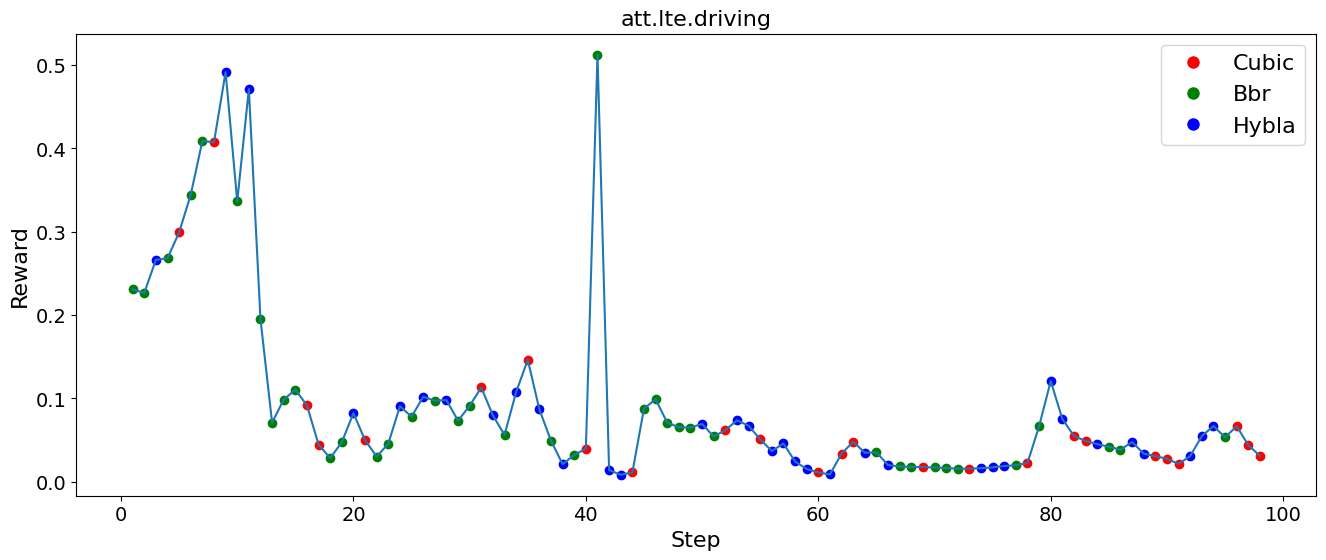

/home/lorenzo/Desktop/mimic-2/log/mab/trace/att.lte.driving.2016.bootstrapped_ucb.2023.04.20.09.32.21.csv



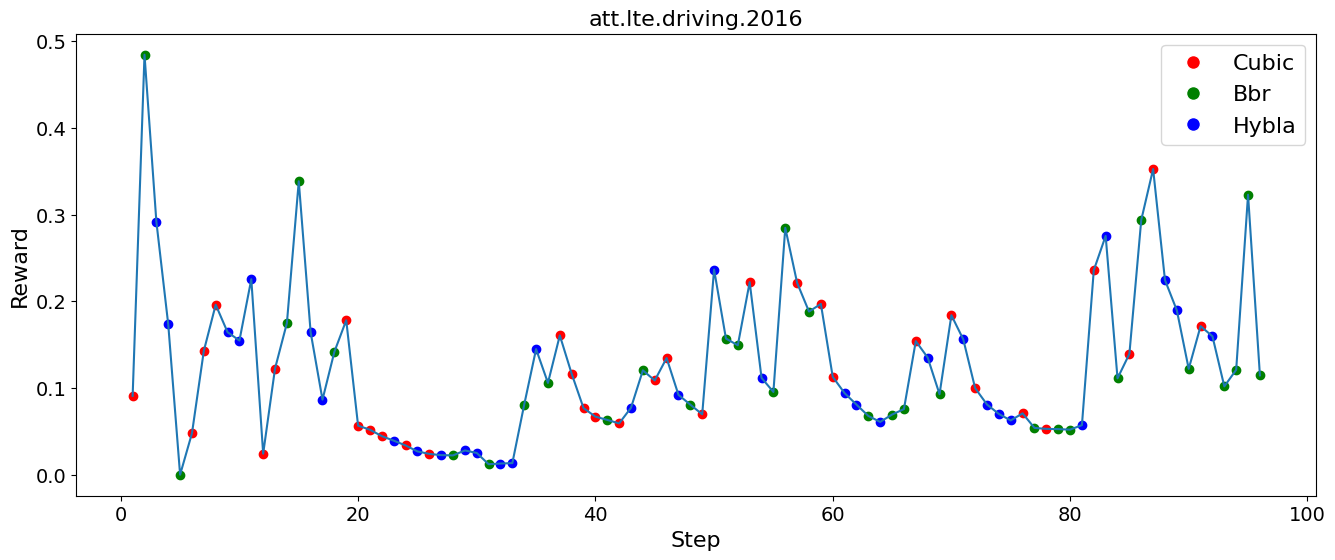

/home/lorenzo/Desktop/mimic-2/log/mab/trace/tm.lte.driving.bootstrapped_ucb.2023.04.20.09.33.24.csv



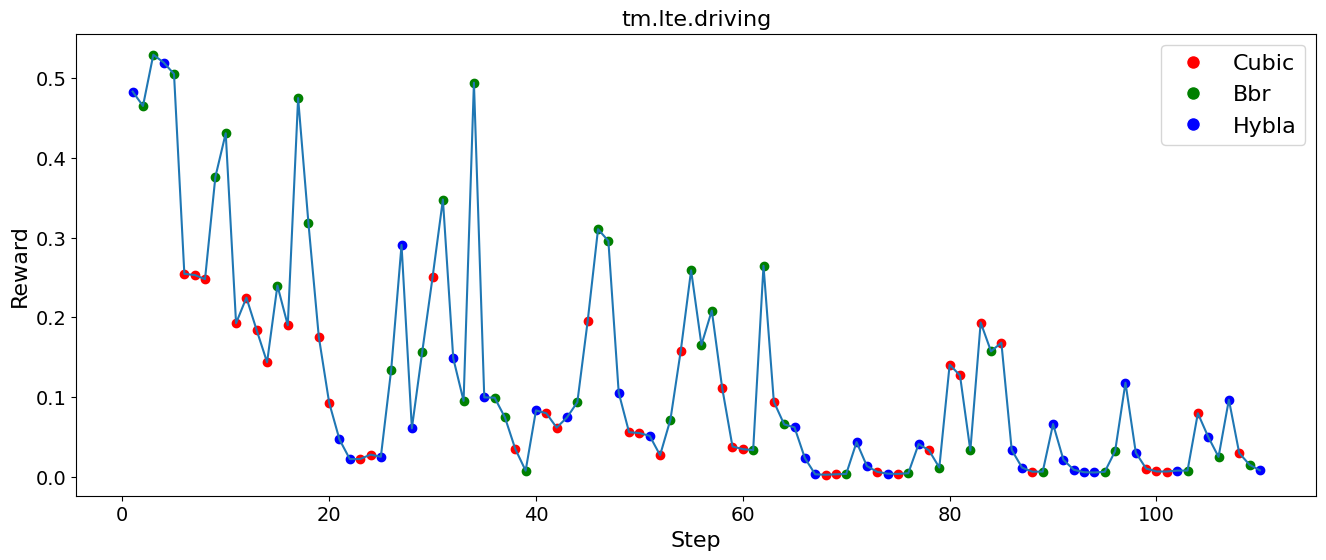

/home/lorenzo/Desktop/mimic-2/log/mab/trace/tm.lte.short.bootstrapped_ucb.2023.04.20.09.34.29.csv



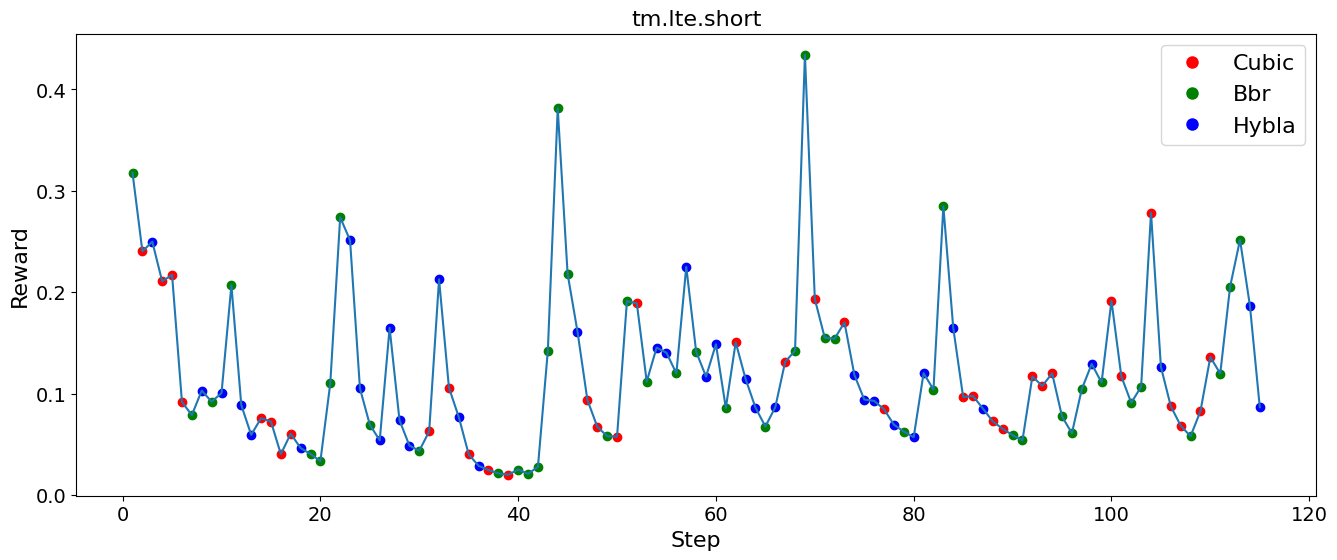

/home/lorenzo/Desktop/mimic-2/log/mab/trace/tm.umts.driving.bootstrapped_ucb.2023.04.20.09.35.32.csv



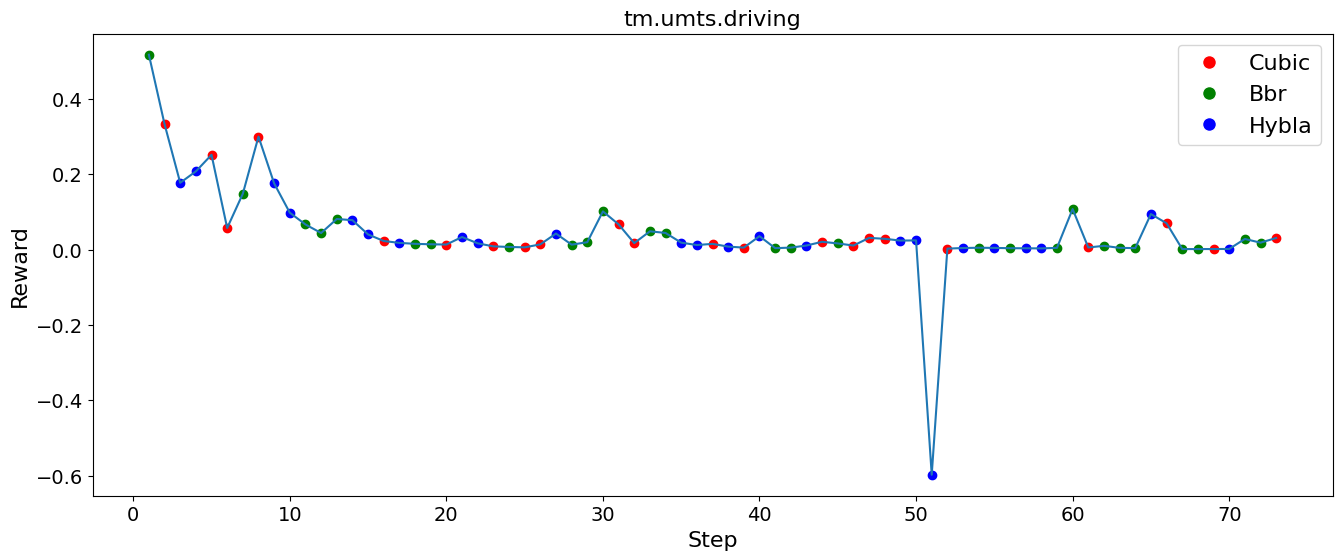

/home/lorenzo/Desktop/mimic-2/log/mab/trace/vz.evdo.driving.bootstrapped_ucb.2023.04.20.09.36.42.csv



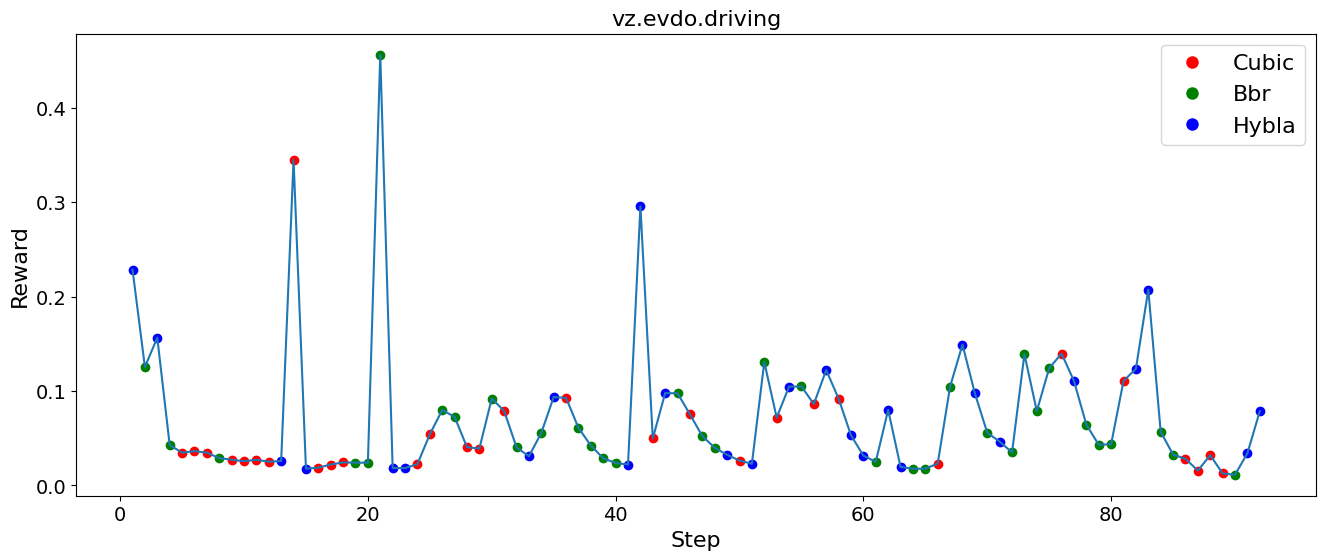

/home/lorenzo/Desktop/mimic-2/log/mab/trace/vz.lte.driving.bootstrapped_ucb.2023.04.20.09.37.48.csv



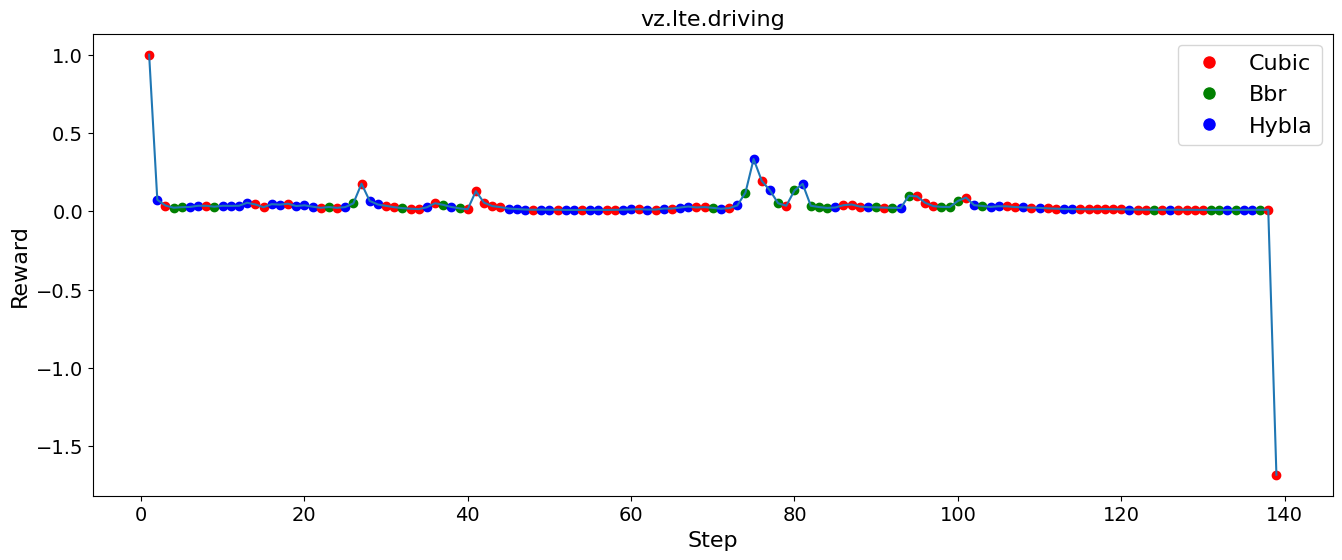

/home/lorenzo/Desktop/mimic-2/log/mab/trace/vz.lte.short.bootstrapped_ucb.2023.04.20.09.39.05.csv



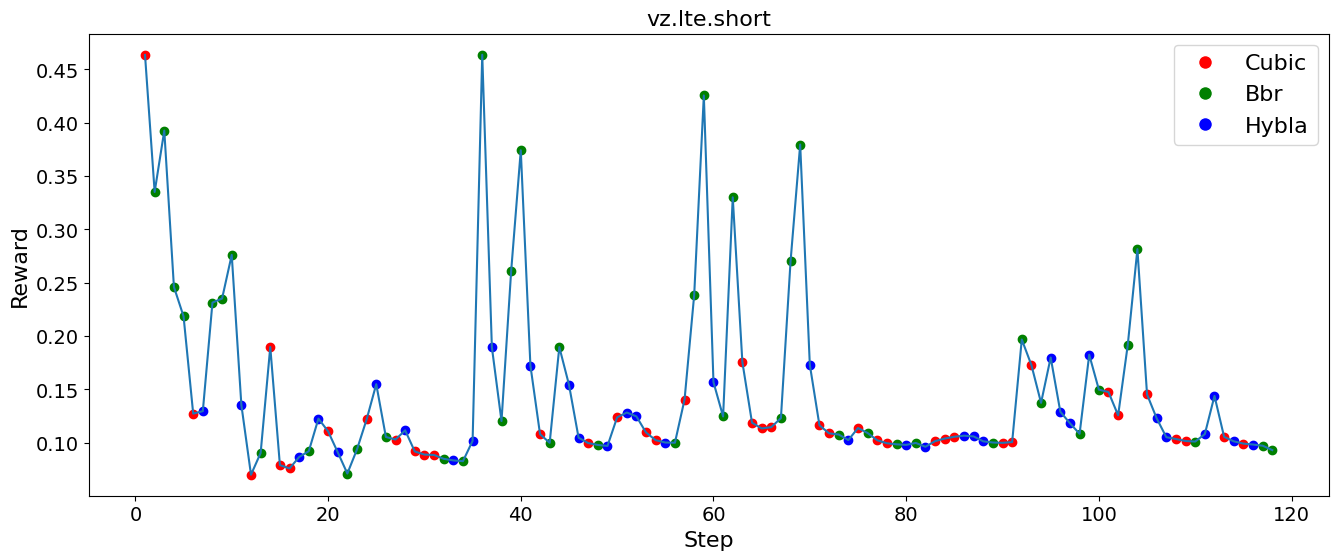

/home/lorenzo/Desktop/mimic-2/log/mab/trace/bus.bootstrapped_ucb.2023.04.20.09.40.09.csv



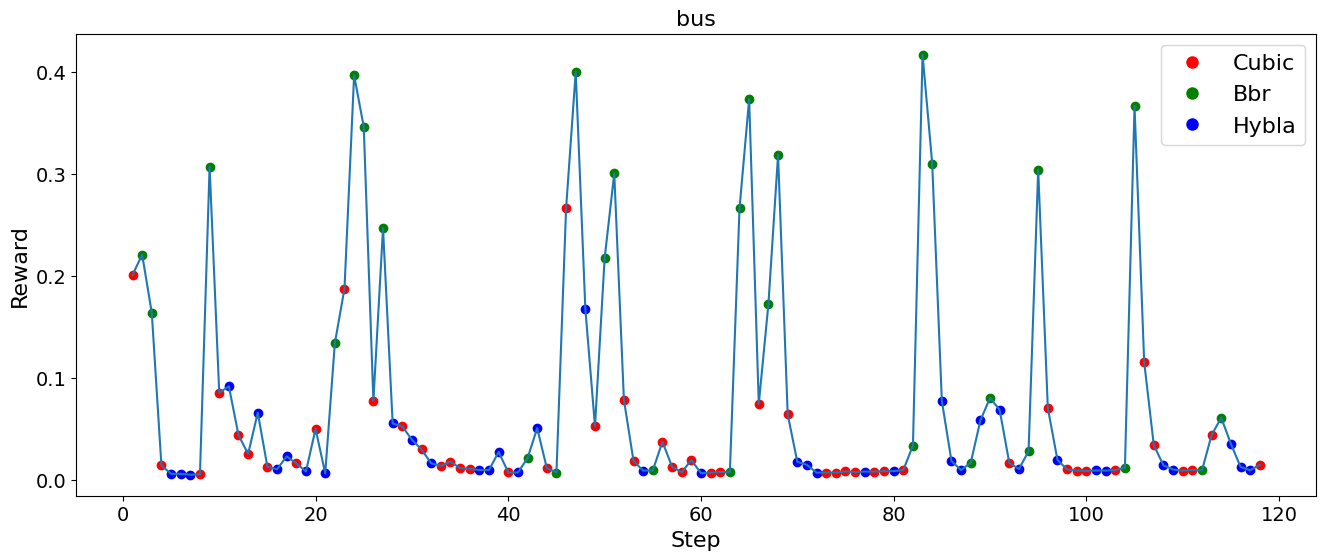

/home/lorenzo/Desktop/mimic-2/log/mab/trace/timessquare.bootstrapped_ucb.2023.04.20.09.41.12.csv



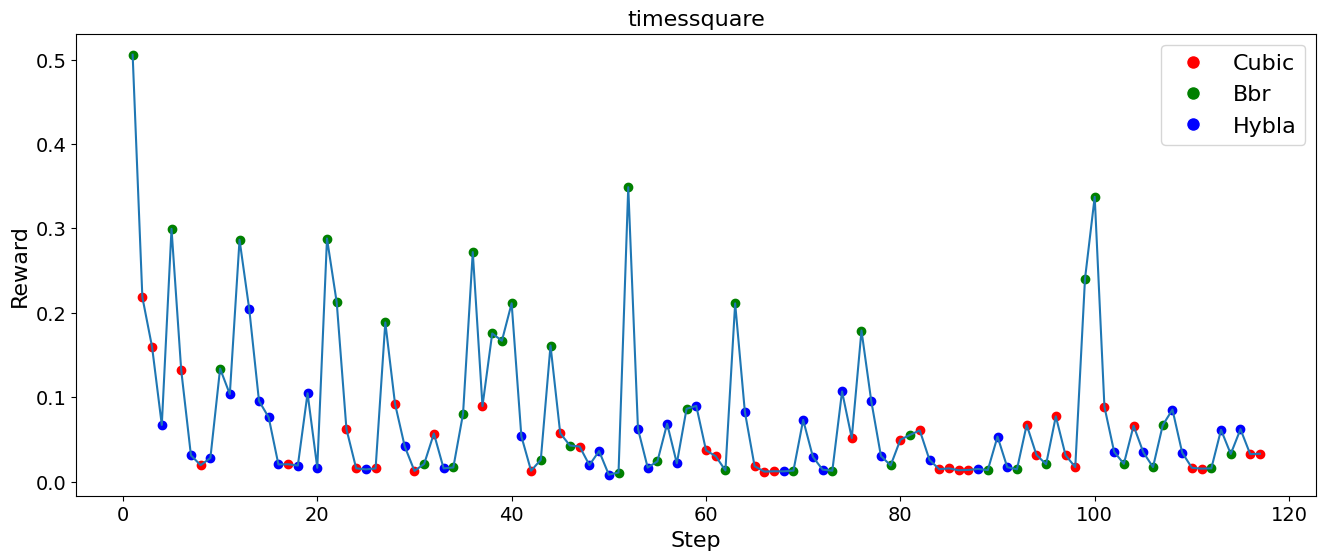

/home/lorenzo/Desktop/mimic-2/log/mab/trace/wired.bootstrapped_ucb.2023.04.20.09.42.16.csv



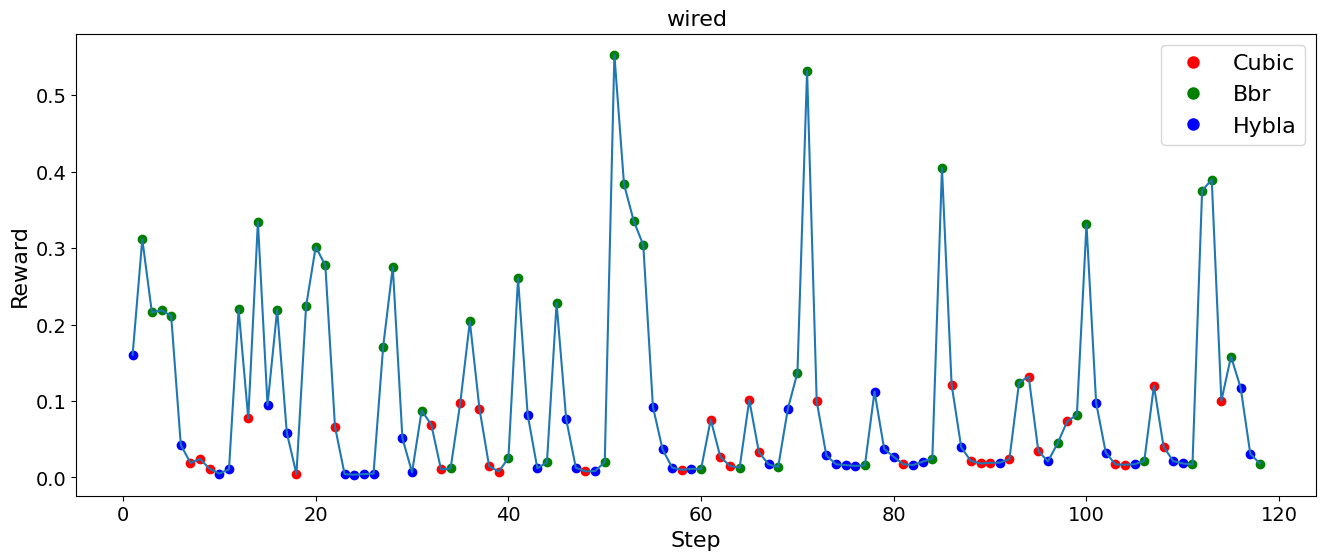

In [10]:
save = False

# Plot protocol selection
for trace in traces:
    timestamp = get_timestamp_from_config(f"{trace}.{policy}")
    csv_filename = get_csv_filename(trace, policy, timestamp)
    features = get_features_from_file(csv_filename)

    print(os.path.join(trace_dir_path, f'{csv_filename}\n'))
    # Extract congestion window values
    actions, rtts, rewards, steps = [], [], [], []
    for row in features:
        actions.append(row['action'])
        rtts.append(row['rtt'])
        rewards.append(row['curr_reward'])
        steps.append(row['step'])
    
    from matplotlib.lines import Line2D
    # plot the data
    fig, ax = plt.subplots(figsize=(16,6))
    ax.set_xlabel('Step', fontsize=16)
    ax.set_ylabel('Reward', fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    ax.plot(steps, rewards)

    # add markers for each step colored by action
    colors = ['red', 'green', 'blue']
    for i in range(len(steps)):
        action_color = colors[int(actions[i])]
        ax.scatter(steps[i], rewards[i], c=action_color, label='')

    # create custom legend
    legend_labels = ['Cubic', 'Bbr', 'Hybla']
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for color, label in zip(colors, legend_labels)]
    ax.legend(handles=legend_elements, fontsize=16)
    ax.set_title(trace, fontsize=16)

    if save:
        filename = f'mab.{policy}.{trace}.reward_vs_action_per_step_comparison.png'
        plt.savefig(os.path.join(f'{path_to_save_dir}', filename))
    
    plt.show()


/home/lorenzo/Desktop/mimic-2/log/mab/trace/att.lte.driving.random_policy.2023.04.06.00.31.42.csv



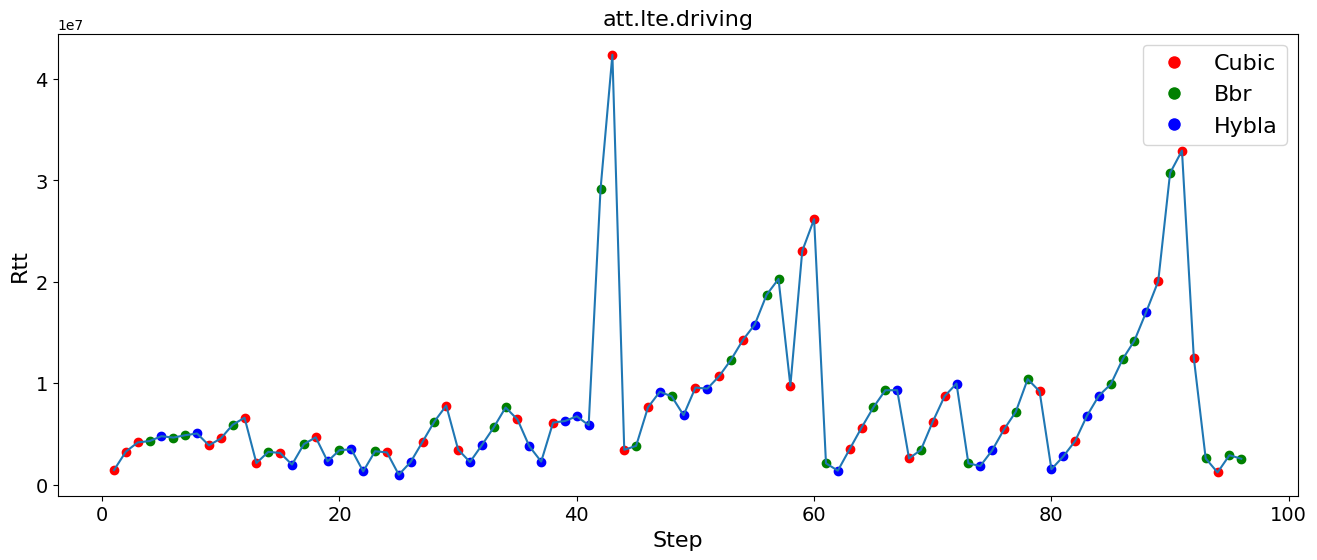

/home/lorenzo/Desktop/mimic-2/log/mab/trace/att.lte.driving.2016.random_policy.2023.04.06.00.32.47.csv



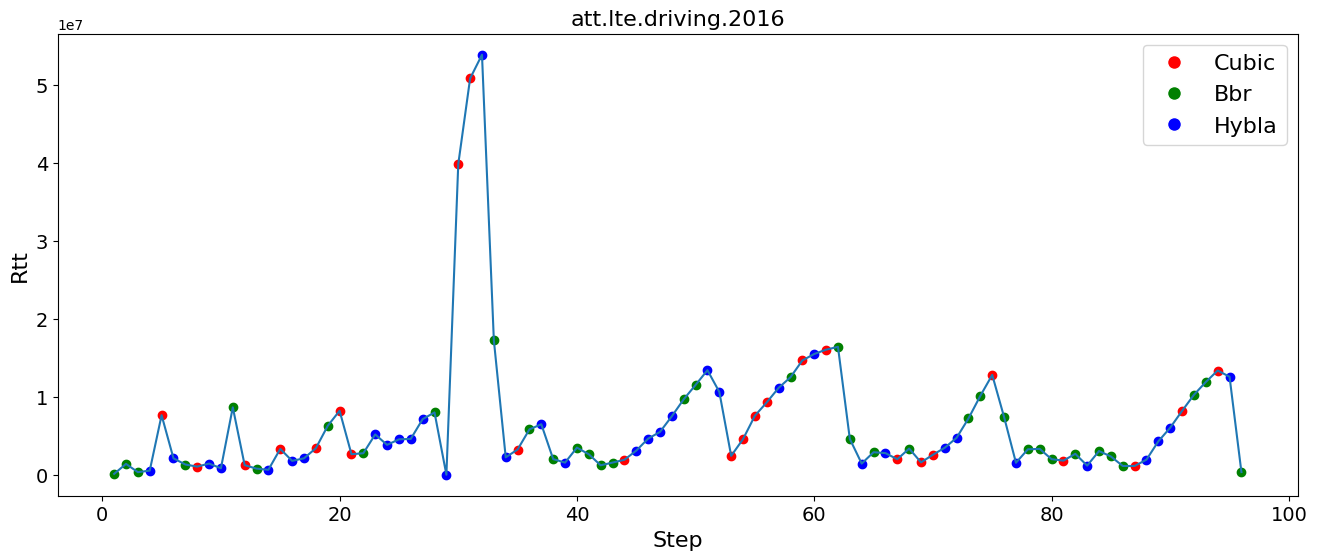

/home/lorenzo/Desktop/mimic-2/log/mab/trace/tm.lte.driving.random_policy.2023.04.06.00.33.50.csv



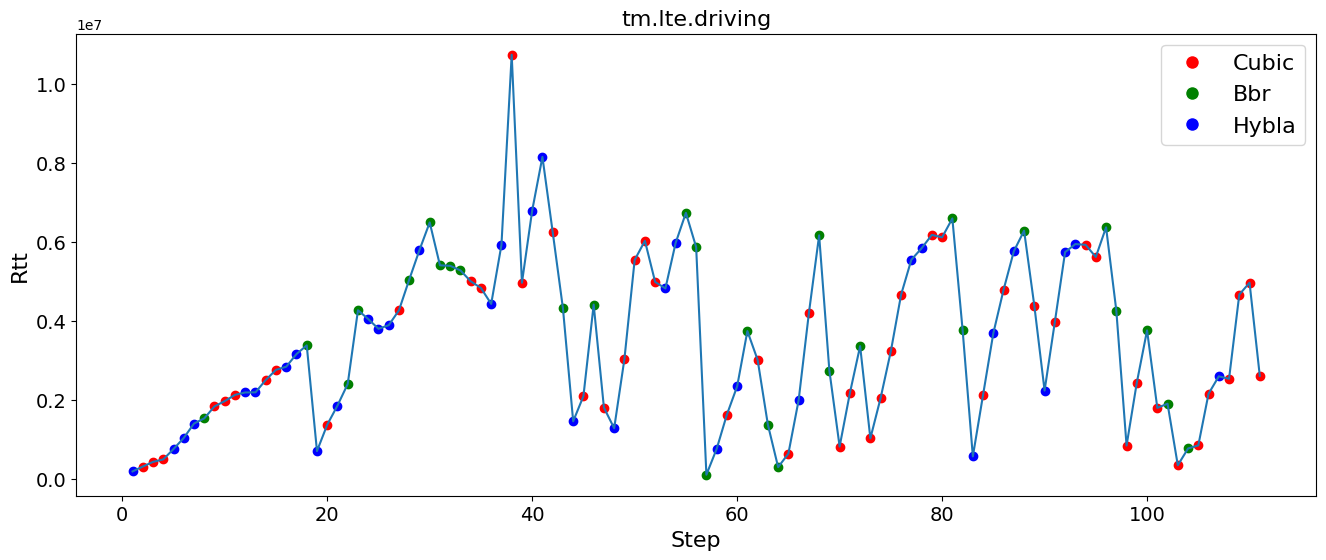

/home/lorenzo/Desktop/mimic-2/log/mab/trace/tm.lte.short.random_policy.2023.04.06.00.34.55.csv



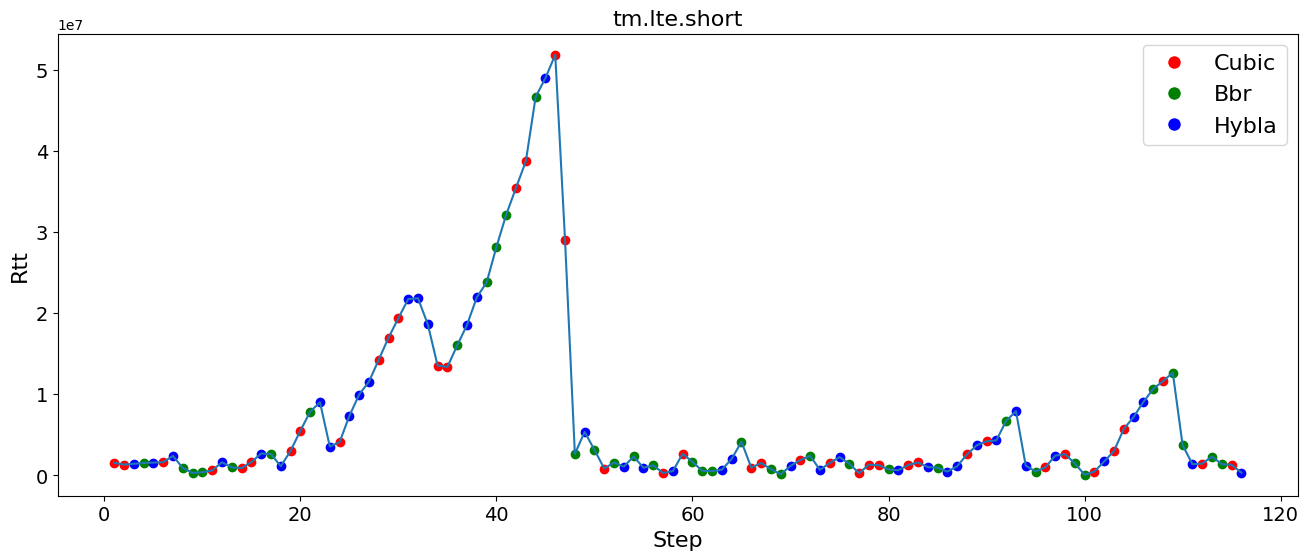

/home/lorenzo/Desktop/mimic-2/log/mab/trace/tm.umts.driving.random_policy.2023.04.06.00.35.58.csv



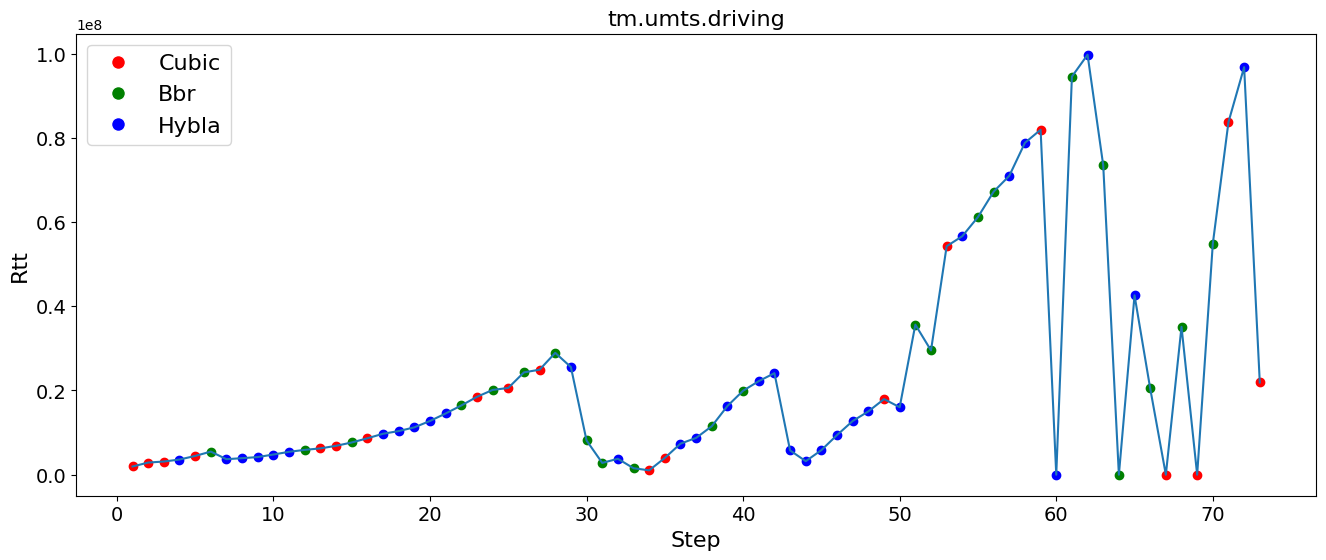

/home/lorenzo/Desktop/mimic-2/log/mab/trace/vz.evdo.driving.random_policy.2023.04.06.00.37.06.csv



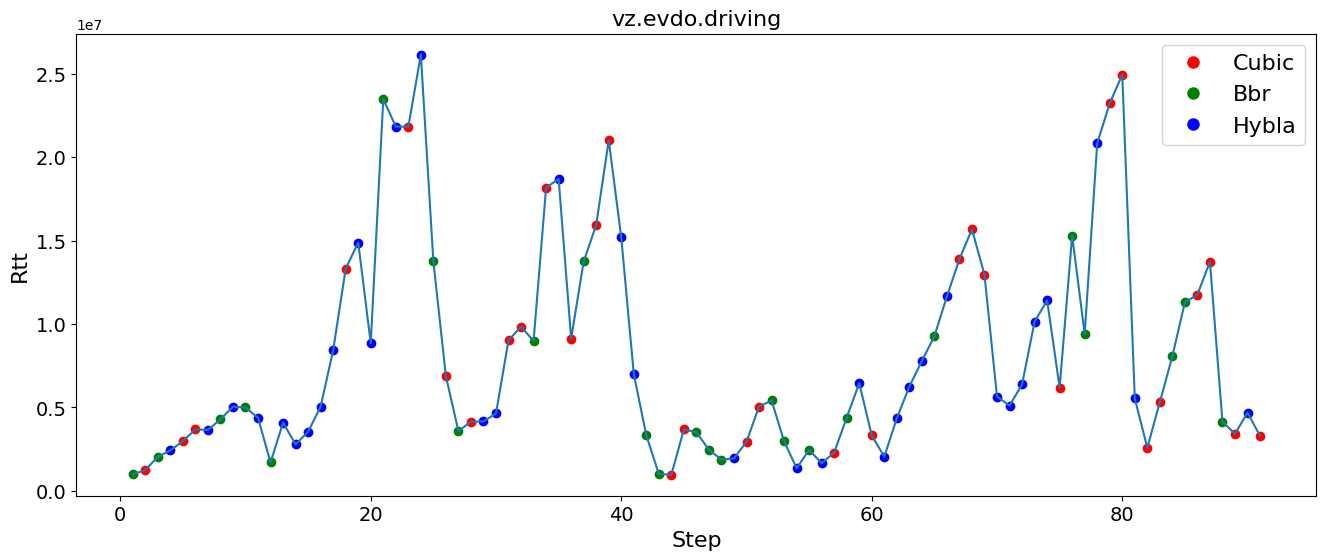

/home/lorenzo/Desktop/mimic-2/log/mab/trace/vz.lte.driving.random_policy.2023.04.06.00.38.10.csv



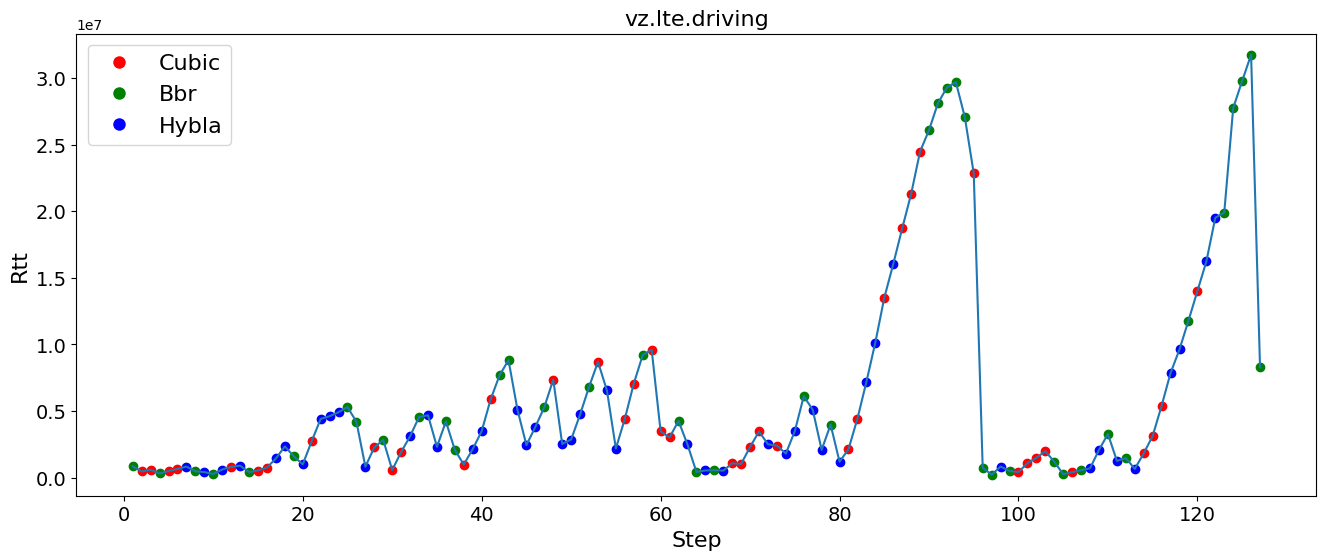

/home/lorenzo/Desktop/mimic-2/log/mab/trace/vz.lte.short.random_policy.2023.04.06.00.39.20.csv



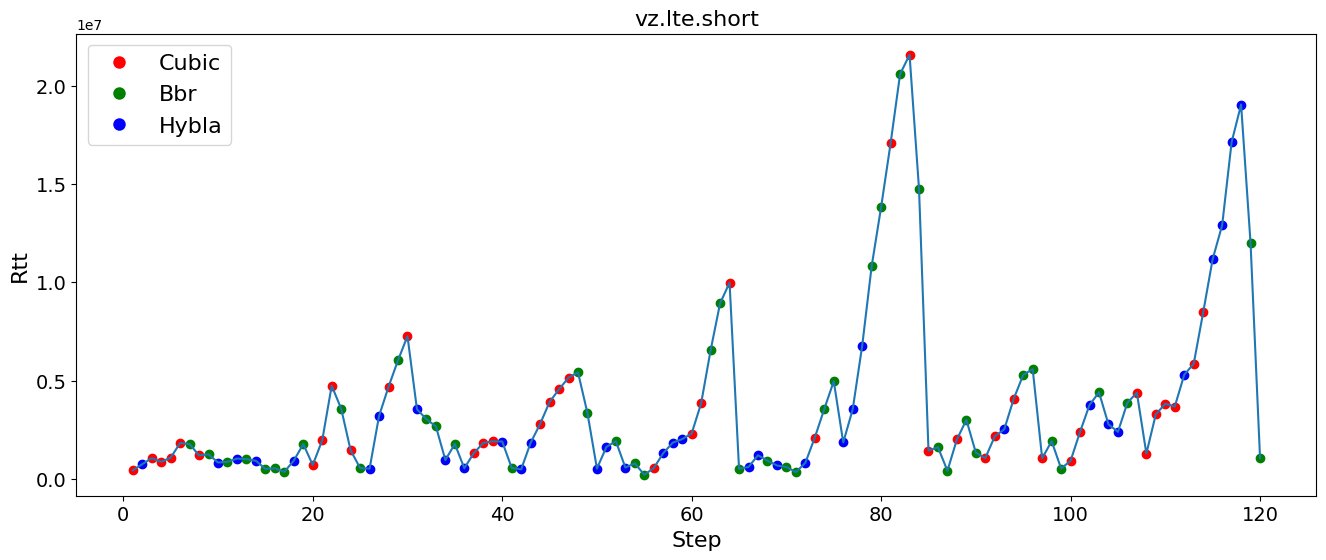

/home/lorenzo/Desktop/mimic-2/log/mab/trace/bus.random_policy.2023.04.06.00.40.25.csv



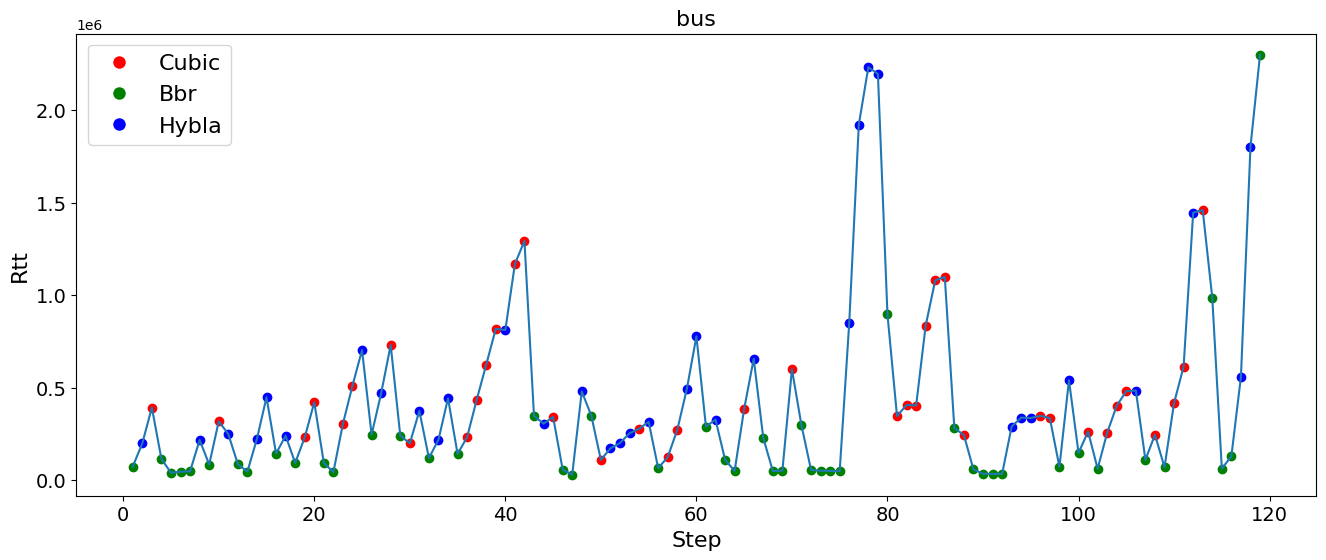

/home/lorenzo/Desktop/mimic-2/log/mab/trace/timessquare.random_policy.2023.04.06.00.41.28.csv



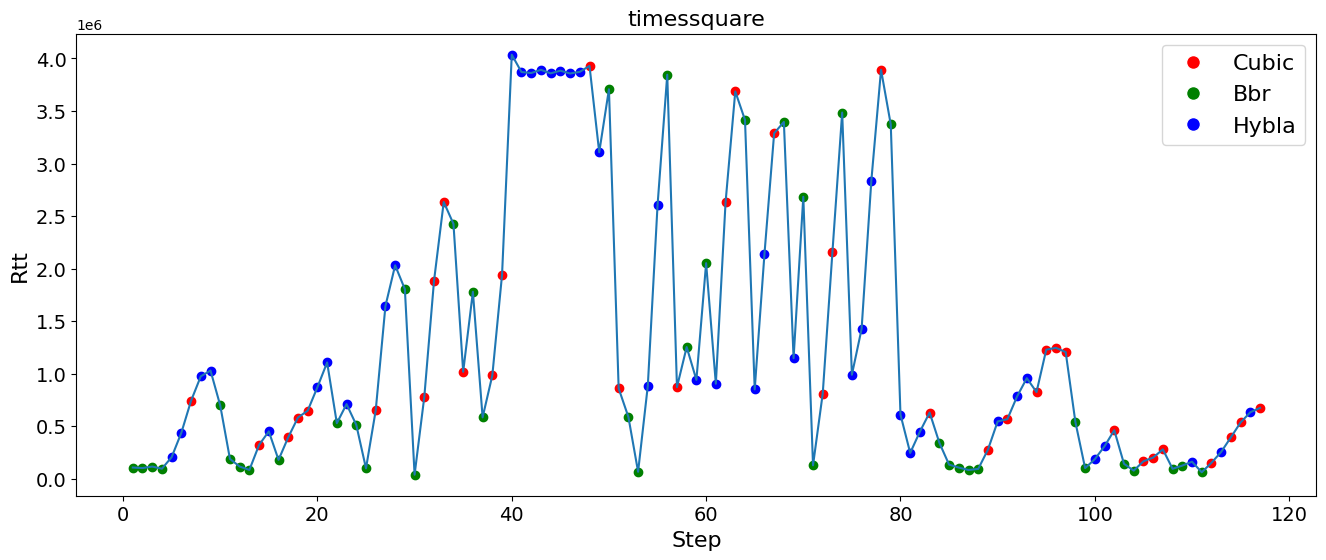

/home/lorenzo/Desktop/mimic-2/log/mab/trace/wired.random_policy.2023.04.06.00.42.31.csv



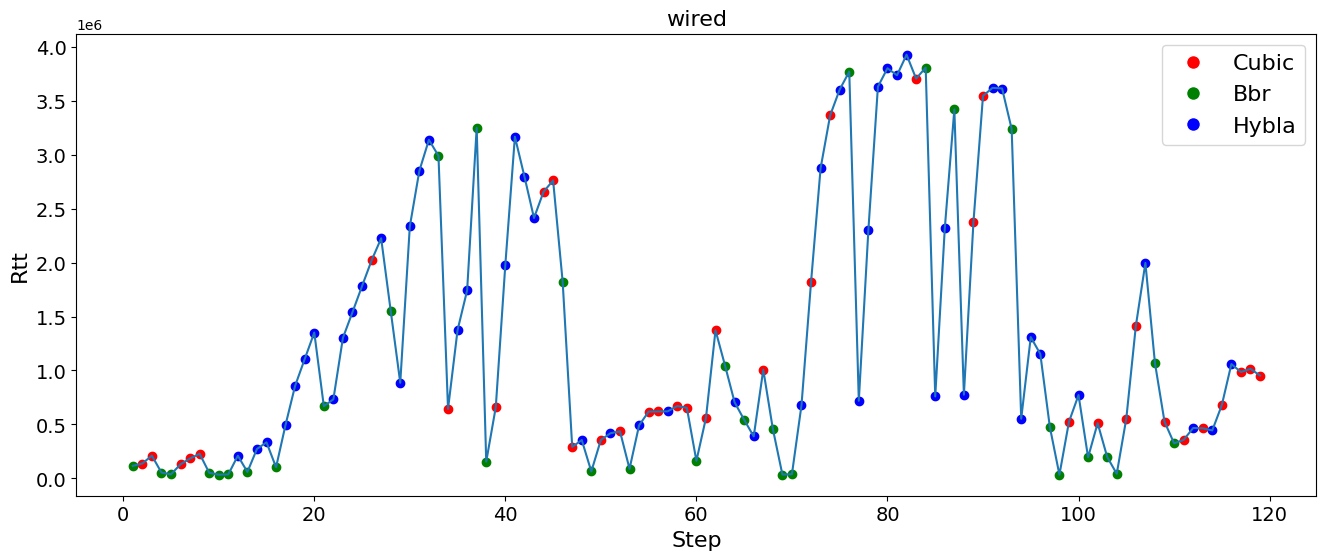

In [18]:
# Plot protocol selection
for trace in traces:
    timestamp = get_timestamp_from_config(f"{trace}.{policy}")
    csv_filename = get_csv_filename(trace, policy, timestamp)
    features = get_features_from_file(csv_filename)

    print(os.path.join(trace_dir_path, f'{csv_filename}\n'))
    # Extract congestion window values
    actions, rtts, rewards, steps = [], [], [], []
    for row in features:
        actions.append(row['action'])
        rtts.append(row['rtt'])
        steps.append(row['step'])
    
    from matplotlib.lines import Line2D
    # plot the data
    fig, ax = plt.subplots(figsize=(16,6))
    ax.set_xlabel('Step', fontsize=16)
    ax.set_ylabel('Rtt', fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    ax.plot(steps, rtts)

    # add markers for each step colored by action
    colors = ['red', 'green', 'blue']
    for i in range(len(steps)):
        action_color = colors[int(actions[i])]
        ax.scatter(steps[i], rtts[i], c=action_color, label='')

    # create custom legend
    legend_labels = ['Cubic', 'Bbr', 'Hybla']
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for color, label in zip(colors, legend_labels)]
    ax.legend(handles=legend_elements, fontsize=16)
    ax.set_title(trace, fontsize=16)

    if save:
        filename = f'mab.{policy}.{trace}.rtt_vs_action_per_step_comparison.png'
        plt.savefig(os.path.join(f'{path_to_save_dir}', filename))

    plt.show()
